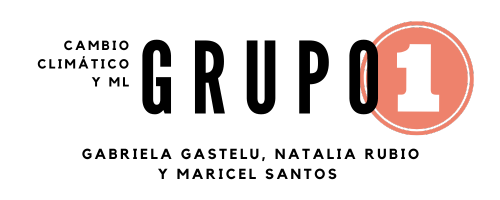



#Segunda Entrega Mentoría Cambio climático y ML
En esta segunda entrega vamos a seguir una serie de pasos propuestos en el TP1 y reforzados luego de la devolución del mismo. Consistirá en dejar listo el dataset para ser introducido a modelos de aprendizaje automático.

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('talk')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder , StandardScaler , MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer , KNNImputer
from sklearn.linear_model import BayesianRidge

In [177]:
energy_df = pd.read_csv('https://raw.githubusercontent.com/TamaraMaggioni/Cambio-climatico-y-ML/main/energy.csv')

energy_df = energy_df.drop('Unnamed: 0', axis=1)

##Modificaciones al dataset completo

En primer lugar volveremos a chequear según lo propuesto el tipo de datos y valores nulos en cada columna utilizando el metodo info de pandas

In [178]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   facility_type              75757 non-null  object 
 1   floor_area                 75757 non-null  float64
 2   year_built                 73920 non-null  float64
 3   energy_star_rating         49048 non-null  float64
 4   ELEVATION                  75757 non-null  float64
 5   cooling_degree_days        75757 non-null  int64  
 6   heating_degree_days        75757 non-null  int64  
 7   precipitation_inches       75757 non-null  float64
 8   snowfall_inches            75757 non-null  float64
 9   snowdepth_inches           75757 non-null  int64  
 10  days_below_30F             75757 non-null  int64  
 11  days_below_20F             75757 non-null  int64  
 12  days_below_10F             75757 non-null  int64  
 13  days_below_0F              75757 non-null  int

Obtenemos la misma información dada por la biblioteca missigno utilizada en el TP1. Sin embargo, en esta instancia vamos agregar el analisis de valores que también representan datos faltantes a través de la búsqueda de ceros en las variables númericas.

In [179]:
resumen_ceros = (energy_df == 0).sum()
resumen_ceros

facility_type                    0
floor_area                       0
year_built                       6
energy_star_rating               1
ELEVATION                        0
cooling_degree_days              1
heating_degree_days              0
precipitation_inches             2
snowfall_inches               8726
snowdepth_inches              8740
days_below_30F                2678
days_below_20F               11228
days_below_10F               30625
days_below_0F                57405
days_above_80F                   8
days_above_90F                 471
days_above_100F              71692
days_above_110F              75696
direction_max_wind_speed         0
direction_peak_wind_speed        0
max_wind_speed                   0
days_with_fog                    0
site_eui                         0
winter_average_temp              0
summer_average_temp              0
fall_average_temp                0
spring_average_temp              0
winter_average_maxtemp           0
summer_average_maxte

De estas columnas hay algunas que tienen sentido que tomen el valor cero y otras que no.

Las que no tienen sentido son:

year_built  -----------------                   6

energy_star_rating   ---            1

Con el año de construcción no hay dudas. Sin embargo, energy star rating es una escala de 0 al 100. Si bien es muy raro puntuar con cero a un edificio, podría ser posible. En base a lo que decidamos hay que pasar estos valores como NaN, sin embargo son muy pocos, por lo que volver hacer un calculo de datos faltantes no sería necesario, estas columnas ya fueron sometidas a analisis y a desición.



In [180]:
energy_df["year_built"] = energy_df["year_built"].replace(0, np.nan)

Por otro lado, tenemos las columnas:  

cooling_degree_days----         1  
Tiene sentido porque esta puede haber alguna locación que no necesitó regrigeración.  
precipitation_inches----          2  
Tiene sentido porque pueden existir locaciones que no registren lluvias.   
snowfall_inches----              8726  
Tiene sentido porque pueden existir locaciones que no registren nieve.   
snowdepth_inches----              8740  
Tiene sentido porque pueden existir locaciones que no registren nieve.  

Todas las que siguen tienen sentido porque puede que en la locación no se registren temperaturas en estos rangos.   
days_below_30F----                2678  
days_below_20F----               11228  
days_below_10F----               30625  
days_below_0F----                57405  
days_above_80F----                   8  
days_above_90F----                 471    
days_above_100F----              71692    
days_above_110F----              75696

Sin embargo, en este ultimo caso, que no existan dias en los limites de temperatura hace que las columnas no aporten información y puedan tratarse como datos faltantes. Por lo que tomaremos el mismo criterio para eliminar columnas que tomen cero en más del 50% del dataset

In [181]:
#Porcentaje de ceros en cada columnas
round(resumen_ceros/(energy_df.shape[0]),2)

facility_type                0.00
floor_area                   0.00
year_built                   0.00
energy_star_rating           0.00
ELEVATION                    0.00
cooling_degree_days          0.00
heating_degree_days          0.00
precipitation_inches         0.00
snowfall_inches              0.12
snowdepth_inches             0.12
days_below_30F               0.04
days_below_20F               0.15
days_below_10F               0.40
days_below_0F                0.76
days_above_80F               0.00
days_above_90F               0.01
days_above_100F              0.95
days_above_110F              1.00
direction_max_wind_speed     0.00
direction_peak_wind_speed    0.00
max_wind_speed               0.00
days_with_fog                0.00
site_eui                     0.00
winter_average_temp          0.00
summer_average_temp          0.00
fall_average_temp            0.00
spring_average_temp          0.00
winter_average_maxtemp       0.00
summer_average_maxtemp       0.00
fall_average_m

De esta forma deberiamos eliminar las columnas

days_below_0F -----              0.76  
days_above_100F ---              0.95  
days_above_110F ----             1.00  

Ahora chequeamos en la variable categorica si existen valores nulos que no sean NaN, como un guión u otro.

In [182]:
energy_df.facility_type.unique()

array(['Food', 'Warehouse', 'Commercial', 'Educational', 'Office',
       'Data_Center', 'Healthcare', 'Industrial', 'Public_Assembly',
       'Lodging', 'Religious_worship', 'Parking_Garage',
       'Public_Services', 'Residential', 'Public_Safety'], dtype=object)

Podemos ver que no existe una categoria equivalente a nan

###Eliminación columnas datos faltantes mayor al 50%
Una vez chequeada esta información podemos seguir con la premisa planteada en el TP1 de eliminar las columnas que tienen menos del 50% de los datos:  "days_with_fog", "direction_peak_wind_speed", "direction_max_wind_speed", "max_wind_speed". Sumando en este caso "days_below_0F", "days_above_100F" y "days_above_110F".Dejando year_built y energy_star_rating para trabajar luego con imputación.
Cabe destacar que cada vez que realicemos uno de estos procedimientos sobre el data set generaremos una copia con el nombre de número(i) del proceso: "energy_df_p(i)"

In [183]:
eliminarcolumnaspordatosfaltantes= ["days_below_0F", "days_above_100F" ,"days_above_110F","days_with_fog", "direction_peak_wind_speed", "direction_max_wind_speed", "max_wind_speed"]
energy_df_p1 = energy_df.copy()
energy_df_p1 = energy_df_p1.drop(eliminarcolumnaspordatosfaltantes, axis=1)

###Eliminacion filas duplicadas
Ahora procedemos a trabajar con las filas. Eliminaremos aquella filas duplicadas, ya que no aportan información al modelo y aumentan el gasto computacional.

El metódo duplicate genera una serie de booleanos donde la fila duplicada (todas las columnas toman exactamente el mismo valor que otra fila) toma el valor True. Luego generamos un corte de estas filas y las contamos. Dando un total de 39 filas.

In [184]:
duplicados = energy_df_p1.duplicated() #Devuelve serie booleana donde True es duplicado (en su segunda aparición)
filas_duplicadas = energy_df_p1[duplicados]
len(filas_duplicadas)

39

Si queremos eliminar los duplicados

In [185]:
energy_df_p2= energy_df_p1.copy()
energy_df_p2 = energy_df_p2.drop_duplicates().reset_index(drop=True)

###Cambio de unidades al SI
En el siguiente paso vamos aplicar un cambio de escala a Sistema internacional (SI)

In [186]:
energy_df_p3 = energy_df_p2.copy()
columnas_F=['cooling_degree_days', 'heating_degree_days','winter_average_temp',
            'summer_average_temp', 'fall_average_temp', 'spring_average_temp',
            'winter_average_maxtemp', 'summer_average_maxtemp',
            'fall_average_maxtemp', 'spring_average_maxtemp',
            'winter_average_mintemp', 'summer_average_mintemp',
            'fall_average_mintemp', 'spring_average_mintemp']
energy_df_p3[columnas_F] = (energy_df_p3[columnas_F] - 32) * 5/9 #Pasaje a Celsius
columnas_inches= ['precipitation_inches', 'snowfall_inches', 'snowdepth_inches']
energy_df_p3[columnas_inches] = energy_df_p3[columnas_inches] * 25.4 #Pasaje a mm
energy_df_p3['floor_area'] = energy_df_p3['floor_area']* 0.092903 #Pasaje a m2
energy_df_p3['site_eui'] = energy_df_p3['site_eui']*0.292875 #para obtener el equivalente en kWh/m2.

###Traducción de los features
En el siguiente paso, vamos aplicar el curado propuesto de cambiar los nombres del inglés al español. Ya que los resultados serán presentados a nuestros compañeros hispanohablantes.

In [187]:
# Renombrar varias columnas
nuevos_nombres = {'facility_type': 'tipo_instalación', 'floor_area': 'superficie_cubierta_m2', 'year_built': 'año_construcción', 'energy_star_rating': 'ranking_eficiencia_energética',
       'ELEVATION': 'altura', 'cooling_degree_days': 'grados_regrigeración_diaria', 'heating_degree_days': 'grados_calefacción_diaria',
       'precipitation_inches': 'precipitaciones_mm', 'snowfall_inches': 'nevadas_mm', 'snowdepth_inches': 'altura_nieve_mm',
       'days_below_30F': 'dias_bajo_menos1C', 'days_below_20F': 'dias_bajo_menos7C', 'days_below_10F': 'dias_bajo_menos12C',
       'days_above_80F': 'dias_sobre_27C', 'days_above_90F': 'dias_sobre_32C',
       'site_eui': 'intensidad_uso_energia', 'winter_average_temp' : 'temp_media_invierno', 'summer_average_temp': 'temp_media_verano',
       'fall_average_temp': 'temp_media_otoño', 'spring_average_temp': 'temp_media_primavera', 'winter_average_maxtemp': 'maxtemp_media_invierno',
       'summer_average_maxtemp':'maxtemp_media_verano', 'fall_average_maxtemp': 'maxtemp_media_otoño',
       'spring_average_maxtemp':'maxtemp_media_primavera', 'winter_average_mintemp' : 'mintemp_media_invierno',
       'summer_average_mintemp': 'mintemp_media_verano', 'fall_average_mintemp':'mintemp_media_otoño',
       'spring_average_mintemp': 'mintemp_media_primavera'}
energy_df_p4 = energy_df_p3.copy()
energy_df_p4 = energy_df_p4.rename(columns=nuevos_nombres)

###Agrupación variable categorica

Procedemos a las instalaciones con menos de 1% en una variable que llamaremos "otros"

In [188]:
type_count = energy_df_p4['tipo_instalación'].value_counts()
type_total = energy_df_p4['tipo_instalación'].count()

type_perc = type_count *100 / type_total

type_perc

Residential          56.267994
Office               16.771441
Educational           7.560950
Commercial            5.746322
Warehouse             3.802266
Lodging               3.760004
Healthcare            2.477614
Public_Assembly       0.944293
Food                  0.814866
Religious_worship     0.526955
Industrial            0.507145
Public_Safety         0.363190
Parking_Garage        0.331493
Public_Services       0.089807
Data_Center           0.035659
Name: tipo_instalación, dtype: float64

In [189]:
energy_df_p5 = energy_df_p4.copy()
energy_df_p5.loc[:,'tipo_instalación'] = energy_df_p5.tipo_instalación.replace({'Residential': 'Residencial',
                                                                                'Office': 'Oficina',
                                                                                'Educational': 'Educativo',
                                                                                'Warehouse': 'Depósito',
                                                                                'Lodging': 'Alojamiento',
                                                                                'Healthcare': 'Salud',
                                                                                'Public_Assembly':'Otros',
                                                                                'Food':'Otros',
                                                                                'Religious_worship':'Otros',
                                                                                'Industrial':'Otros',
                                                                                'Public_Safety':'Otros',
                                                                                'Parking_Garage':'Otros',
                                                                                'Public_Services':'Otros',
                                                                                'Data_Center':'Otros'})

type_count_p5 = energy_df_p5['tipo_instalación'].value_counts()
type_total_p5 = energy_df_p5['tipo_instalación'].count()

type_perc_p5 = type_count_p5 *100 / type_total_p5

type_perc_p5

Residencial    56.267994
Oficina        16.771441
Educativo       7.560950
Commercial      5.746322
Depósito        3.802266
Alojamiento     3.760004
Otros           3.613408
Salud           2.477614
Name: tipo_instalación, dtype: float64

###Estudio de correlación con la variable target y variables explicativas
En esta sección vamos a estudiar la información reduntante analizando los valores de correlación entre las variables explicativas y de ellas con la variable target

In [190]:
numeric_variables = energy_df_p5.select_dtypes(include='number')  # Selecionamos solo variables numéricas
# Calculamos la matriz de correlación
correlation_matrix = numeric_variables.corr()
# Filtramos la matriz para la columna 'intensidad_uso_energia'
intensidad_uso_energia_correlation = correlation_matrix['intensidad_uso_energia']
# Desplegamos los resultados en valor absoluto y ordenadas descendentemente.
abs(intensidad_uso_energia_correlation).sort_values(ascending=False)


intensidad_uso_energia           1.000000
ranking_eficiencia_energética    0.512147
temp_media_invierno              0.163845
nevadas_mm                       0.157571
mintemp_media_invierno           0.156428
grados_calefacción_diaria        0.148129
dias_bajo_menos1C                0.140135
temp_media_verano                0.131386
mintemp_media_primavera          0.129512
grados_regrigeración_diaria      0.125101
dias_bajo_menos7C                0.119870
temp_media_primavera             0.119543
altura_nieve_mm                  0.113474
precipitaciones_mm               0.113319
mintemp_media_verano             0.092233
maxtemp_media_invierno           0.089522
dias_sobre_27C                   0.086551
dias_bajo_menos12C               0.084610
mintemp_media_otoño              0.075988
superficie_cubierta_m2           0.073443
maxtemp_media_primavera          0.061992
maxtemp_media_otoño              0.055051
maxtemp_media_verano             0.021896
año_construcción                 0

Calculamos las correlaciones entre las variables explicativas para identificar variables que brinden información redundante

In [191]:
print("Valores mayores a 0.5:")
for fila_index, fila in correlation_matrix.iterrows():
    for col in correlation_matrix.columns:
        valor = round(fila[col],2)
        if valor > 0.5 and valor != 1:
            print(f"{fila_index}/{col}: {valor}")

Valores mayores a 0.5:
altura/dias_bajo_menos12C: 0.56
grados_regrigeración_diaria/nevadas_mm: 0.57
grados_regrigeración_diaria/dias_sobre_27C: 0.84
grados_regrigeración_diaria/temp_media_verano: 0.97
grados_regrigeración_diaria/maxtemp_media_verano: 0.54
grados_regrigeración_diaria/maxtemp_media_otoño: 0.53
grados_regrigeración_diaria/mintemp_media_verano: 0.72
grados_calefacción_diaria/precipitaciones_mm: 0.66
grados_calefacción_diaria/nevadas_mm: 0.63
grados_calefacción_diaria/dias_bajo_menos1C: 0.83
grados_calefacción_diaria/dias_bajo_menos7C: 0.73
grados_calefacción_diaria/dias_bajo_menos12C: 0.64
precipitaciones_mm/grados_calefacción_diaria: 0.66
precipitaciones_mm/nevadas_mm: 0.56
nevadas_mm/grados_regrigeración_diaria: 0.57
nevadas_mm/grados_calefacción_diaria: 0.63
nevadas_mm/precipitaciones_mm: 0.56
nevadas_mm/altura_nieve_mm: 0.84
nevadas_mm/dias_bajo_menos1C: 0.66
nevadas_mm/dias_bajo_menos7C: 0.67
nevadas_mm/temp_media_verano: 0.54
nevadas_mm/mintemp_media_verano: 0.51
alt

Luego de analizar las correlaciones entre las variables explicativas, podemos observar que la variable grados_regrigeración_diaria esta altamente relacionada con variables climaticas referida a las temperaturas altas y de forma analoga ocurre para la variable grados_calefacción_diaria.

También vemos que existen correlaciones altas de variables que explican la misma condición climática.

Por lo tanto, se eliminarán las siguientes variables:
* dias_sobre_27C
* maxtemp_media_verano
* mintemp_media_verano
* maxtemp_media_primavera
* mintemp_media_primavera
* maxtemp_media_invierno
* mintemp_media_invierno
* precipitaciones_mm
* dias_bajo_menos1C
* dias_bajo_menos7C
* dias_bajo_menos12C
* altura_nieve_mm



In [192]:
eliminarcolumnaspordatoscorrelacionados= ["dias_sobre_27C","maxtemp_media_verano",
"mintemp_media_verano", "maxtemp_media_primavera", "mintemp_media_primavera",
"maxtemp_media_invierno", "mintemp_media_invierno", "precipitaciones_mm",
"dias_bajo_menos1C", "dias_bajo_menos7C", "dias_bajo_menos12C","altura_nieve_mm"]
energy_df_p6 = energy_df_p5.copy()
energy_df_p6 = energy_df_p6.drop(eliminarcolumnaspordatoscorrelacionados, axis=1)

## Separación del dataset en train, test y validación
A continuación separamos el dataset en los 3 grupos que usaremos en el modelo:

*   Train: datos de entrenamiento (70%)
*   Validación: datos para ajustar hiperparámetros (10%)
*   Test: datos para probar el modelo final (20%)  



In [193]:
energy_df_m1 = energy_df_p5.copy() #m1 por si queremos generar luego más de un modelo (m1, m2, mX, ...)
energy_df_m5 = energy_df_p6.copy()

X_m1 = energy_df_m1.drop(['intensidad_uso_energia'],axis=1)
y_m1 = energy_df_m1['intensidad_uso_energia']
X_m5 = energy_df_m5.drop(['intensidad_uso_energia'],axis=1)
y_m5 = energy_df_m5['intensidad_uso_energia']

train_size = 0.7 #70%
test_size = 0.2 / (1 - train_size) #20%
#Queda el 10% restante para val

X_train_m1, X_testval_m1, y_train_m1, y_testval_m1 = train_test_split(X_m1, y_m1, train_size=train_size, random_state=0)
X_train_m5, X_testval_m5, y_train_m5, y_testval_m5 = train_test_split(X_m5, y_m5, train_size=train_size, random_state=0)

X_val_m1, X_test_m1, y_val_m1, y_test_m1 = train_test_split(X_testval_m1, y_testval_m1, test_size=test_size, random_state=0)
#segun lo que busque en scikit no hay una manera de separar en 3 de una sola vez, sino que se puede usar dos veces.
X_val_m5, X_test_m5, y_val_m5, y_test_m5 = train_test_split(X_testval_m5, y_testval_m5, test_size=test_size, random_state=0)

In [194]:
X_train_m1

,tipo_instalación,superficie_cubierta_m2,año_construcción,ranking_eficiencia_energética,altura,grados_regrigeración_diaria,grados_calefacción_diaria,precipitaciones_mm,nevadas_mm,altura_nieve_mm,...,temp_media_otoño,temp_media_primavera,maxtemp_media_invierno,maxtemp_media_verano,maxtemp_media_otoño,maxtemp_media_primavera,mintemp_media_invierno,mintemp_media_verano,mintemp_media_otoño,mintemp_media_primavera
43515,Residencial,5771.227263,1960.0,100.0,3.4,860.555556,2460.000000,1040.638,1247.14,11760.2,...,16.533652,12.011649,13.888889,34.259259,28.333333,24.814815,-9.629630,15.000000,5.000000,-0.740741
35484,Otros,102071.968682,1974.0,NaN,42.7,608.888889,2690.555556,1366.266,1270.00,9575.8,...,14.567105,10.739745,15.370370,32.222222,26.296296,24.629630,-10.925926,15.370370,3.703704,-0.555556
36699,Residencial,9267.074250,1958.0,NaN,42.7,608.888889,2690.555556,1366.266,1270.00,9575.8,...,14.567105,10.739745,15.370370,32.222222,26.296296,24.629630,-10.925926,15.370370,3.703704,-0.555556
38315,Oficina,14307.062000,1986.0,61.0,42.7,608.888889,2690.555556,1366.266,1270.00,9575.8,...,14.567105,10.739745,15.370370,32.222222,26.296296,24.629630,-10.925926,15.370370,3.703704,-0.555556
455,Oficina,2415.478000,1929.0,49.0,2.4,421.666667,1337.222222,489.458,0.00,0.0,...,16.987754,14.867682,21.481481,38.148148,33.333333,29.629630,-1.481481,10.740741,5.740741,3.703704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,Residencial,6206.384915,1928.0,NaN,3.4,691.666667,2192.222222,978.154,243.84,254.0,...,13.836121,13.851653,16.666667,35.000000,25.740741,29.444444,-6.481481,14.259259,4.814815,2.962963
45891,Residencial,11919.454900,2010.0,2.0,42.7,860.555556,2460.000000,1040.638,1247.14,11760.2,...,16.533652,12.011649,13.888889,34.259259,28.333333,24.814815,-9.629630,15.000000,5.000000,-0.740741
42613,Residencial,14050.556817,1961.0,NaN,3.4,860.555556,2460.000000,1040.638,1247.14,11760.2,...,16.533652,12.011649,13.888889,34.259259,28.333333,24.814815,-9.629630,15.000000,5.000000,-0.740741
43567,Oficina,41066.284702,1919.0,74.0,3.4,860.555556,2460.000000,1040.638,1247.14,11760.2,...,16.533652,12.011649,13.888889,34.259259,28.333333,24.814815,-9.629630,15.000000,5.000000,-0.740741


## Modificaciones luego de la separación del dataset



###OneHotEncoding

En este dataset contamos solamente con una variable categórica, la cual no es ordinal. Por lo tanto, decidimos aplicar OneHotEncoding:

In [195]:
X_train_m1.tipo_instalación.unique()

array(['Residencial', 'Otros', 'Oficina', 'Educativo', 'Depósito',
       'Salud', 'Alojamiento', 'Commercial'], dtype=object)

In [196]:
encoder = OneHotEncoder(drop='first') #se eliminó alojamiento
var_cat = ['tipo_instalación']
X_train_m1 = X_train_m1.reset_index(drop=True) #reseateamos el index para poder concatenar al final
X_val_m1 = X_val_m1.reset_index(drop=True)
X_test_m1 = X_test_m1.reset_index(drop=True)
X_train_m5 = X_train_m5.reset_index(drop=True) #reseateamos el index para poder concatenar al final
X_val_m5 = X_val_m5.reset_index(drop=True)
X_test_m5 = X_test_m5.reset_index(drop=True)


encoder.fit(X_train_m1[var_cat].values.reshape(-1, 1)) #fiteamos con las variables categoricas.
                                                       #values.reshape porque no es la única variable del df
encoder.fit(X_train_m5[var_cat].values.reshape(-1, 1))
nombres_columnas_codificadas = encoder.get_feature_names_out(var_cat) #guardamos los nombres que había en la variable

var_cat_cod_train_m1 = encoder.transform(X_train_m1[var_cat].values.reshape(-1, 1)) #transformamos los valores de la variable a partir del fit
df_codificado_train_m1 = pd.DataFrame(var_cat_cod_train_m1.toarray(), columns=nombres_columnas_codificadas) #generamos un nuevo df con las columnas encodeadas y las nombramos como en la variable original
X_train_m1_s1 = pd.concat([X_train_m1, df_codificado_train_m1], axis=1) #concatenamos el df original con el encodeado
X_train_m1_s1 = X_train_m1_s1.drop(columns=['tipo_instalación']) # Eliminamos la vairable original tipo_instalación

var_cat_cod_train_m5 = encoder.transform(X_train_m5[var_cat].values.reshape(-1, 1)) #transformamos los valores de la variable a partir del fit
df_codificado_train_m5 = pd.DataFrame(var_cat_cod_train_m5.toarray(), columns=nombres_columnas_codificadas) #generamos un nuevo df con las columnas encodeadas y las nombramos como en la variable original
X_train_m5_s1 = pd.concat([X_train_m5, df_codificado_train_m5], axis=1) #concatenamos el df original con el encodeado
X_train_m5_s1 = X_train_m5_s1.drop(columns=['tipo_instalación'])

var_cat_cod_test_m1 = encoder.transform(X_test_m1[var_cat].values.reshape(-1, 1))
df_codificado_test_m1 = pd.DataFrame(var_cat_cod_test_m1.toarray(), columns=nombres_columnas_codificadas)
X_test_m1_s1 = pd.concat([X_test_m1, df_codificado_test_m1], axis=1)
X_test_m1_s1 = X_test_m1_s1.drop(columns=['tipo_instalación'])

var_cat_cod_test_m5 = encoder.transform(X_test_m5[var_cat].values.reshape(-1, 1))
df_codificado_test_m5 = pd.DataFrame(var_cat_cod_test_m5.toarray(), columns=nombres_columnas_codificadas)
X_test_m5_s1 = pd.concat([X_test_m5, df_codificado_test_m5], axis=1)
X_test_m5_s1 = X_test_m5_s1.drop(columns=['tipo_instalación'])

var_cat_cod_val_m1 = encoder.transform(X_val_m1[var_cat].values.reshape(-1, 1))
df_codificado_val_m1 = pd.DataFrame(var_cat_cod_val_m1.toarray(), columns=nombres_columnas_codificadas)
X_val_m1_s1 = pd.concat([X_val_m1, df_codificado_val_m1], axis=1)
X_val_m1_s1 = X_val_m1_s1.drop(columns=['tipo_instalación'])

var_cat_cod_val_m5 = encoder.transform(X_val_m5[var_cat].values.reshape(-1, 1))
df_codificado_val_m5 = pd.DataFrame(var_cat_cod_val_m5.toarray(), columns=nombres_columnas_codificadas)
X_val_m5_s1 = pd.concat([X_val_m5, df_codificado_val_m5], axis=1)
X_val_m5_s1 = X_val_m5_s1.drop(columns=['tipo_instalación'])


In [197]:
X_val_m1_s1

,superficie_cubierta_m2,año_construcción,ranking_eficiencia_energética,altura,grados_regrigeración_diaria,grados_calefacción_diaria,precipitaciones_mm,nevadas_mm,altura_nieve_mm,dias_bajo_menos1C,...,mintemp_media_verano,mintemp_media_otoño,mintemp_media_primavera,tipo_instalación_Commercial,tipo_instalación_Depósito,tipo_instalación_Educativo,tipo_instalación_Oficina,tipo_instalación_Otros,tipo_instalación_Residencial,tipo_instalación_Salud
0,19188.464329,2005.0,55.0,42.7,608.888889,2690.555556,1366.266,1270.00,9575.8,66,...,15.370370,3.703704,-0.555556,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,41892.471081,2002.0,38.0,44.2,788.333333,2391.666667,1107.694,375.92,304.8,74,...,14.814815,2.962963,-1.481481,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,21827.002432,1928.0,75.0,198.1,754.444444,3002.222222,1089.406,693.42,3911.6,92,...,10.000000,1.111111,-4.259259,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,16510.999869,1949.0,89.0,32.9,854.444444,2281.111111,942.848,762.00,1574.8,69,...,14.629630,3.148148,-0.185185,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4647.844187,1962.0,NaN,42.7,691.666667,2192.222222,978.154,243.84,254.0,22,...,14.259259,4.814815,2.962963,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7567,11612.875000,1960.0,86.0,42.7,860.555556,2460.000000,1040.638,1247.14,11760.2,63,...,15.000000,5.000000,-0.740741,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7568,9399.461025,1966.0,97.0,3.4,809.444444,2344.444444,1071.118,914.40,2565.4,40,...,14.814815,5.555556,-0.185185,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7569,6492.804864,1930.0,NaN,21.3,431.111111,3253.888889,1122.934,855.98,7493.0,124,...,8.148148,-3.148148,-6.111111,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7570,10459.855867,2011.0,100.0,42.7,608.888889,2690.555556,1366.266,1270.00,9575.8,66,...,15.370370,3.703704,-0.555556,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Eliminación outliers

Aplicaremos el método del rango intercuartil para eliminar outliers del conjunto de train

In [198]:
var_cuant_m1 = ['superficie_cubierta_m2', 'año_construcción',
       'ranking_eficiencia_energética', 'altura',
       'grados_regrigeración_diaria', 'grados_calefacción_diaria',
       'precipitaciones_mm', 'nevadas_mm', 'altura_nieve_mm',
       'dias_bajo_menos1C', 'dias_bajo_menos7C', 'dias_bajo_menos12C',
       'dias_sobre_27C', 'dias_sobre_32C',
       'temp_media_invierno',
       'temp_media_verano', 'temp_media_otoño', 'temp_media_primavera',
       'maxtemp_media_invierno', 'maxtemp_media_verano', 'maxtemp_media_otoño',
       'maxtemp_media_primavera', 'mintemp_media_invierno',
       'mintemp_media_verano', 'mintemp_media_otoño',
       'mintemp_media_primavera']
var_cuant_m5 = [x for x in var_cuant_m1 if x not in eliminarcolumnaspordatoscorrelacionados]

X_train_m1_var_cuant= X_train_m1_s1[var_cuant_m1]
Q1_m1 = X_train_m1_var_cuant.quantile(0.25)
Q3_m1 = X_train_m1_var_cuant.quantile(0.75)
IQR_m1 = Q3_m1 - Q1_m1
lower_bound_m1 = Q1_m1 - 1.5 * IQR_m1
upper_bound_m1 = Q3_m1 + 1.5 * IQR_m1
outliers_m1 = ((X_train_m1_var_cuant < lower_bound_m1) | (X_train_m1_var_cuant > upper_bound_m1)).any(axis=1)
X_train_no_outliers_m1 = X_train_m1_var_cuant[~outliers_m1]

X_train_m5_var_cuant= X_train_m5_s1[var_cuant_m5]
Q1_m5 = X_train_m5_var_cuant.quantile(0.25)
Q3_m5 = X_train_m5_var_cuant.quantile(0.75)
IQR_m5 = Q3_m5 - Q1_m5
lower_bound_m5 = Q1_m5 - 1.5 * IQR_m5
upper_bound_m5 = Q3_m5 + 1.5 * IQR_m5
outliers_m5 = ((X_train_m5_var_cuant < lower_bound_m5) | (X_train_m5_var_cuant > upper_bound_m5)).any(axis=1)
X_train_no_outliers_m5 = X_train_m5_var_cuant[~outliers_m5]
var_cuant_m5

df_codificado_train_no_outliers_m1 = df_codificado_train_m1[~outliers_m1]
df_codificado_train_no_outliers_m1 = df_codificado_train_no_outliers_m1.reset_index(drop=True)
X_train_no_outliers_m1 = X_train_no_outliers_m1.reset_index(drop=True)
X_train_m1_s2 = pd.concat([X_train_no_outliers_m1, df_codificado_train_no_outliers_m1], axis=1)

df_codificado_train_no_outliers_m5 = df_codificado_train_m5[~outliers_m5]
df_codificado_train_no_outliers_m5 = df_codificado_train_no_outliers_m5.reset_index(drop=True)
X_train_no_outliers_m5 = X_train_no_outliers_m5.reset_index(drop=True)
X_train_m5_s2 = pd.concat([X_train_no_outliers_m5, df_codificado_train_no_outliers_m5], axis=1)

In [199]:
X_train_m1_s2

,superficie_cubierta_m2,año_construcción,ranking_eficiencia_energética,altura,grados_regrigeración_diaria,grados_calefacción_diaria,precipitaciones_mm,nevadas_mm,altura_nieve_mm,dias_bajo_menos1C,...,mintemp_media_verano,mintemp_media_otoño,mintemp_media_primavera,tipo_instalación_Commercial,tipo_instalación_Depósito,tipo_instalación_Educativo,tipo_instalación_Oficina,tipo_instalación_Otros,tipo_instalación_Residencial,tipo_instalación_Salud
0,5771.227263,1960.0,100.0,3.4,860.555556,2460.000000,1040.638,1247.14,11760.2,63,...,15.000000,5.000000,-0.740741,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,9267.074250,1958.0,NaN,42.7,608.888889,2690.555556,1366.266,1270.00,9575.8,66,...,15.370370,3.703704,-0.555556,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,14307.062000,1986.0,61.0,42.7,608.888889,2690.555556,1366.266,1270.00,9575.8,66,...,15.370370,3.703704,-0.555556,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,5235.084050,1930.0,NaN,3.4,608.888889,2690.555556,1366.266,1270.00,9575.8,66,...,15.370370,3.703704,-0.555556,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,11778.706855,1911.0,NaN,42.7,691.666667,2192.222222,978.154,243.84,254.0,22,...,14.259259,4.814815,2.962963,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32076,20810.272000,1922.0,94.0,42.7,608.888889,2690.555556,1366.266,1270.00,9575.8,66,...,15.370370,3.703704,-0.555556,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32077,6206.384915,1928.0,NaN,3.4,691.666667,2192.222222,978.154,243.84,254.0,22,...,14.259259,4.814815,2.962963,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32078,11919.454900,2010.0,2.0,42.7,860.555556,2460.000000,1040.638,1247.14,11760.2,63,...,15.000000,5.000000,-0.740741,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32079,14050.556817,1961.0,NaN,3.4,860.555556,2460.000000,1040.638,1247.14,11760.2,63,...,15.000000,5.000000,-0.740741,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Normalización de variables

Se generará un modelo con las variables normalizadas y otro con las variables escaladas para comparar.

In [200]:
scaler1_m1 = StandardScaler()

X_train_normal_m1 = scaler1_m1.fit_transform(X_train_m1_s2[var_cuant_m1])
df_normal_train_m1 = pd.DataFrame(X_train_normal_m1, columns=X_train_m1_s2[var_cuant_m1].columns)
X_train_m1_s3 = pd.concat([df_normal_train_m1, df_codificado_train_no_outliers_m1], axis=1)

X_test_normal_m1 = scaler1_m1.transform(X_test_m1_s1[var_cuant_m1])
df_normal_test_m1 = pd.DataFrame(X_test_normal_m1, columns=X_test_m1_s1[var_cuant_m1].columns)
X_test_m1_s3 = pd.concat([df_normal_test_m1, df_codificado_test_m1], axis=1)

X_val_normal_m1 = scaler1_m1.transform(X_val_m1_s1[var_cuant_m1])
df_normal_val_m1 = pd.DataFrame(X_val_normal_m1, columns=X_val_m1_s1[var_cuant_m1].columns)
X_val_m1_s3 = pd.concat([df_normal_val_m1, df_codificado_val_m1], axis=1)

In [201]:
scaler1_m5 = StandardScaler()

X_train_normal_m5 = scaler1_m5.fit_transform(X_train_m5_s2[var_cuant_m5])
df_normal_train_m5 = pd.DataFrame(X_train_normal_m5, columns=X_train_m5_s2[var_cuant_m5].columns)
X_train_m5_s3 = pd.concat([df_normal_train_m5, df_codificado_train_no_outliers_m5], axis=1)

X_test_normal_m5 = scaler1_m5.transform(X_test_m5_s1[var_cuant_m5])
df_normal_test_m5 = pd.DataFrame(X_test_normal_m5, columns=X_test_m5_s1[var_cuant_m5].columns)
X_test_m5_s3 = pd.concat([df_normal_test_m5, df_codificado_test_m5], axis=1)

X_val_normal_m5 = scaler1_m5.transform(X_val_m5_s1[var_cuant_m5])
df_normal_val_m5 = pd.DataFrame(X_val_normal_m5, columns=X_val_m5_s1[var_cuant_m5].columns)
X_val_m5_s3 = pd.concat([df_normal_val_m5, df_codificado_val_m5], axis=1)

In [202]:
X_train_m1_s3

,superficie_cubierta_m2,año_construcción,ranking_eficiencia_energética,altura,grados_regrigeración_diaria,grados_calefacción_diaria,precipitaciones_mm,nevadas_mm,altura_nieve_mm,dias_bajo_menos1C,...,mintemp_media_verano,mintemp_media_otoño,mintemp_media_primavera,tipo_instalación_Commercial,tipo_instalación_Depósito,tipo_instalación_Educativo,tipo_instalación_Oficina,tipo_instalación_Otros,tipo_instalación_Residencial,tipo_instalación_Salud
0,-0.760366,0.386030,1.414686,-1.233061,1.308513,0.075078,-0.629715,0.976901,1.480455,0.878132,...,0.393063,0.549799,-0.782573,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.128964,0.319607,NaN,1.235526,-1.478174,1.460607,1.884870,1.040319,0.997565,1.067013,...,1.298781,-0.642736,-0.645747,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.781333,1.249533,0.064300,1.235526,-1.478174,1.460607,1.884870,1.040319,0.997565,1.067013,...,1.298781,-0.642736,-0.645747,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.857201,-0.610318,NaN,-1.233061,-1.478174,1.460607,1.884870,1.040319,0.997565,1.067013,...,1.298781,-0.642736,-0.645747,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.324674,-1.241339,NaN,1.235526,-0.561582,-1.534139,-1.112233,-1.806456,-1.063141,-1.703242,...,-1.418373,0.379437,1.953939,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32076,1.955910,-0.876011,1.206934,1.235526,-1.478174,1.460607,1.884870,1.040319,0.997565,1.067013,...,1.298781,-0.642736,-0.645747,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32077,-0.681770,-0.676742,NaN,-1.233061,-0.561582,-1.534139,-1.112233,-1.806456,-1.063141,-1.703242,...,-1.418373,0.379437,1.953939,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32078,0.350096,2.046611,-1.978591,1.235526,1.308513,0.075078,-0.629715,0.976901,1.480455,0.878132,...,0.393063,0.549799,-0.782573,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32079,0.735004,0.419242,NaN,-1.233061,1.308513,0.075078,-0.629715,0.976901,1.480455,0.878132,...,0.393063,0.549799,-0.782573,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Escalado de variables

Se probó el escalado de variables como alternativa a la normalización. Ambos dataset serán probados en los modelos.

In [203]:
scaler2_m2 = MinMaxScaler()

X_train_normal_m2 = scaler2_m2.fit_transform(X_train_m1_s2[var_cuant_m1])
df_normal_train_m2 = pd.DataFrame(X_train_normal_m2, columns=X_train_m1_s2[var_cuant_m1].columns)
X_train_m2_s4 = pd.concat([df_normal_train_m2, df_codificado_train_no_outliers_m1], axis=1)

X_test_normal_m2 = scaler2_m2.transform(X_test_m1_s1[var_cuant_m1])
df_normal_test_m2 = pd.DataFrame(X_test_normal_m2, columns=X_test_m1_s1[var_cuant_m1].columns)
X_test_m2_s4 = pd.concat([df_normal_test_m2, df_codificado_test_m1], axis=1)

X_val_normal_m2 = scaler2_m2.transform(X_val_m1_s1[var_cuant_m1])
df_normal_val_m2 = pd.DataFrame(X_val_normal_m2, columns=X_val_m1_s1[var_cuant_m1].columns)
X_val_m2_s4 = pd.concat([df_normal_val_m2, df_codificado_val_m1], axis=1)

In [204]:
scaler2_m6 = MinMaxScaler()

X_train_normal_m6 = scaler2_m6.fit_transform(X_train_m5_s2[var_cuant_m5])
df_normal_train_m6 = pd.DataFrame(X_train_normal_m6, columns=X_train_m5_s2[var_cuant_m5].columns)
X_train_m6_s4 = pd.concat([df_normal_train_m6, df_codificado_train_no_outliers_m5], axis=1)

X_test_normal_m6 = scaler2_m6.transform(X_test_m5_s1[var_cuant_m5])
df_normal_test_m6 = pd.DataFrame(X_test_normal_m5, columns=X_test_m5_s1[var_cuant_m5].columns)
X_test_m6_s4 = pd.concat([df_normal_test_m6, df_codificado_test_m5], axis=1)

X_val_normal_m6 = scaler2_m6.transform(X_val_m5_s1[var_cuant_m5])
df_normal_val_m6 = pd.DataFrame(X_val_normal_m6, columns=X_val_m5_s1[var_cuant_m5].columns)
X_val_m6_s4 = pd.concat([df_normal_val_m6, df_codificado_val_m5], axis=1)

###Imputación

Imputación
En el análisis del práctico anterior se identificaron las variables que presentaban datos faltantes. Para lo cual se propuso eliminar aquellas variables que tuvieran más del 50 % de datos faltantes e imputar a aquellas que tuvieran menos porcentaje de faltante.
Cabe destacar que uno de los modelos que se analizará será el que se obtengan de incluir las variables con los datos imputados comparándolo con los demás modelos plantados. Ya que una dificultad sería que puede que en la realidad estas variables siempre presenten gran cantidad de faltantes, lo cual dificultaría las futuras predicciones.


Utilizamos dos métodos de imputación para así comparar la eficiencia de cada uno.

####Imputación KNN

Se probaron 2 metodos para llevar a cabo la imputación KNN debido a que IterativeImputer imprimia un warning de no convergencia:

In [205]:
var_imput = ['año_construcción', 'ranking_eficiencia_energética']
mice_imputer_1_m3 = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(),max_iter=500)

X_train_m3_s6 = X_train_m1_s3.copy()
X_train_m3_s6 [var_imput] = mice_imputer_1_m3.fit_transform(X_train_m3_s6[var_imput])

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [206]:
mice_imputer_2_m3 = KNNImputer()
X_train_m3_s5 = X_train_m1_s3.copy()

X_train_m3_s5 [var_imput] = mice_imputer_2_m3.fit_transform(X_train_m3_s5[var_imput])

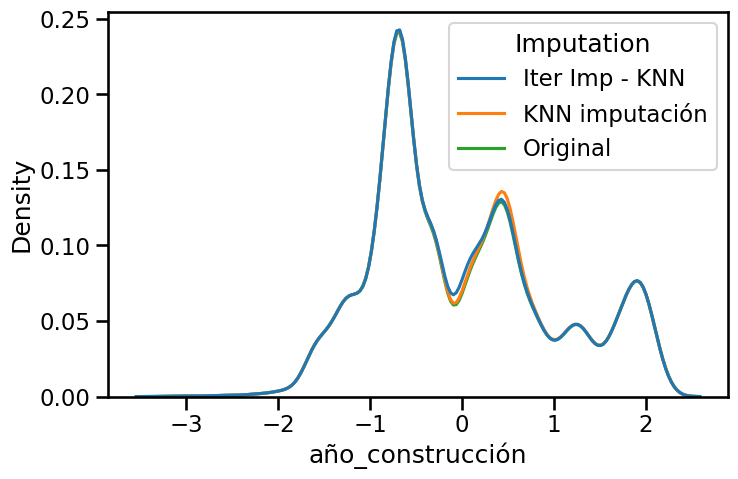

In [207]:
mice_1_año_construcción = X_train_m3_s5.año_construcción.to_frame()
mice_1_año_construcción['Imputation'] = 'Iter Imp - KNN' #agrego esta columna
mice_2_año_construcción = X_train_m3_s6.año_construcción.to_frame()
mice_2_año_construcción['Imputation'] = 'KNN imputación' #agrego esta columna
X_train_m1_s3_año_construcción = X_train_m1_s3.año_construcción.dropna().to_frame()
X_train_m1_s3_año_construcción ['Imputation'] = 'Original' #agrego esta columna


data = pd.concat([mice_1_año_construcción, mice_2_año_construcción, X_train_m1_s3_año_construcción])
fig = plt.figure(figsize=(8, 5))
g = sns.kdeplot(data=data, x='año_construcción', hue='Imputation')

El gráfico anterior representa las distribuciones de la base de datos original y la obtenida luego de la imputación con el método  IterativeImputer con KNRegressor y KNNImputer para la variable Año de Construcción. Podemos observar que la distribucón de la base con los datos imputados mantiene la forma de la distribución original. Si bien no se observa gran diferencia entre ambas imputaciones, KNNImputer no presentó ningún warning.

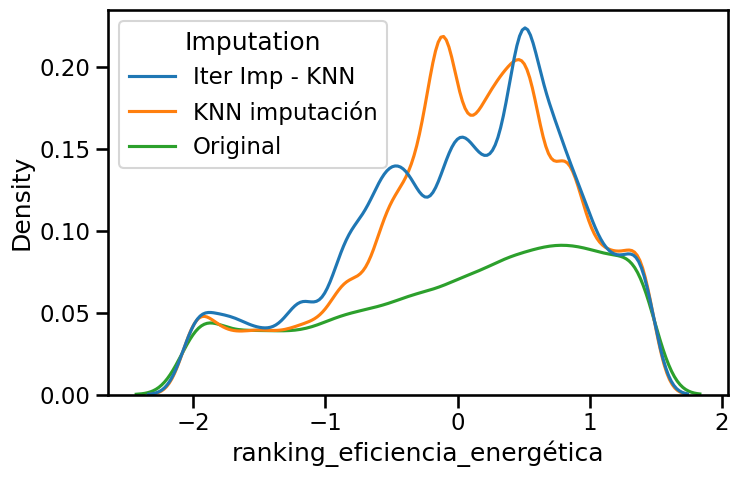

In [208]:
mice_1_ree = X_train_m3_s5.ranking_eficiencia_energética.to_frame()
mice_1_ree['Imputation'] = 'Iter Imp - KNN' #agrego esta columna
mice_2_ree = X_train_m3_s6.ranking_eficiencia_energética.to_frame()
mice_2_ree['Imputation'] = 'KNN imputación' #agrego esta columna
X_train_m1_s3_ree = X_train_m1_s3.ranking_eficiencia_energética.dropna().to_frame()
X_train_m1_s3_ree['Imputation'] = 'Original' #agrego esta columna


data = pd.concat([mice_1_ree, mice_2_ree, X_train_m1_s3_ree])
fig = plt.figure(figsize=(8, 5))
g = sns.kdeplot(data=data, x='ranking_eficiencia_energética', hue='Imputation')

Al momento de comparar las distribución de la base original y las que tiene los datos imputados para la variable Ranking de Eficiencia energética, vemos que existe una diferencia significativa con los datos originales. La eficiencia de esta imputación se analizará al momento de modelar.

Como se dijo anteriormente, KNNImputer no presentó ningún warning y, por ese motivo, decidimos quedarnos con ese modelo de imputación de KNN.

####Imputacion Bayesiana

In [209]:
#Ahora implementamos otro método de imputación, Ridge Bayesiano
mice_imputer_3_m3 = IterativeImputer(random_state=0, estimator= BayesianRidge())
X_train_m3_s7 = X_train_m1_s3.copy()

X_train_m3_s7 [var_imput] = mice_imputer_3_m3.fit_transform(X_train_m3_s7[var_imput])

Grafico para comparar los datos originales con los imputados

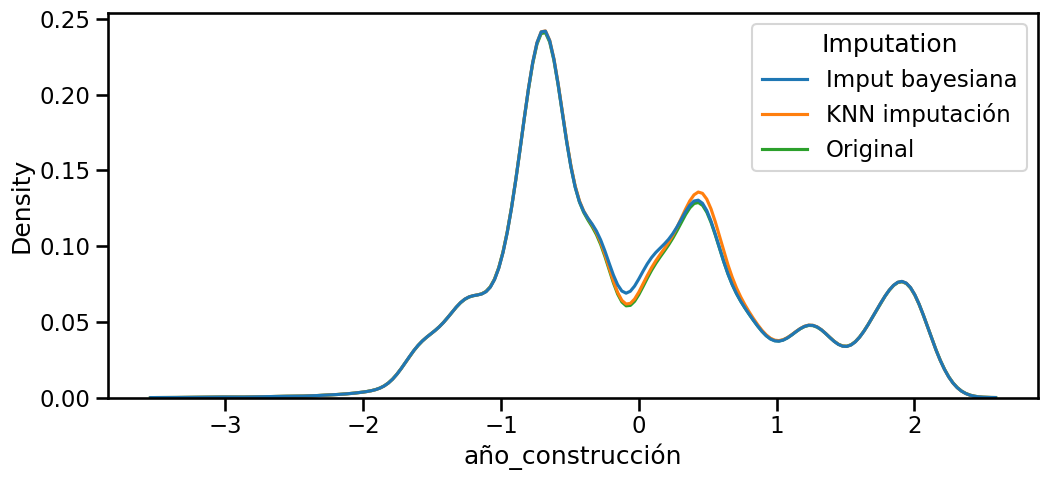

In [210]:
mice_3_año_construcción = X_train_m3_s7.año_construcción.to_frame()
mice_3_año_construcción['Imputation'] = 'Imput bayesiana' #agrego esta columna

data = pd.concat([mice_3_año_construcción, mice_2_año_construcción, X_train_m1_s3_año_construcción])
fig = plt.figure(figsize=(12, 5))
g = sns.kdeplot(data=data, x='año_construcción', hue='Imputation')


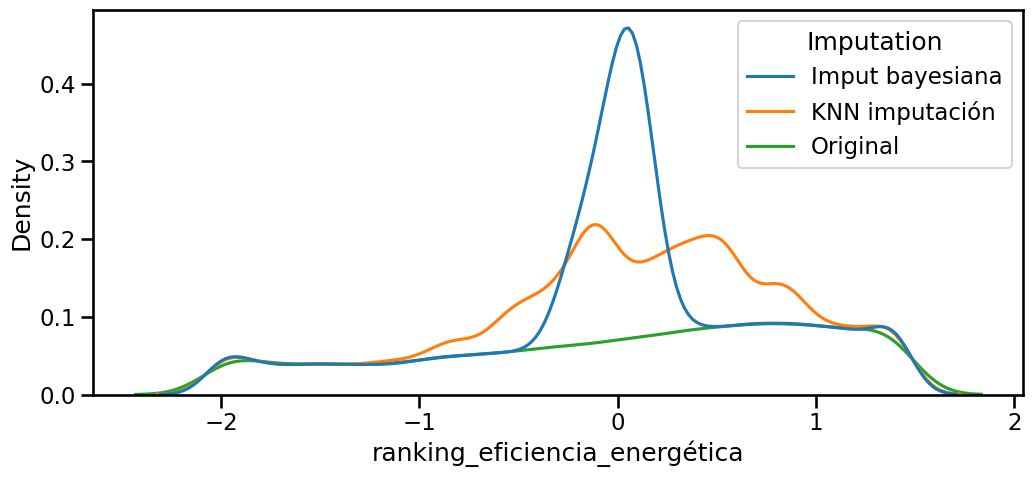

In [211]:
mice_3_ree = X_train_m3_s7.ranking_eficiencia_energética.to_frame()
mice_3_ree['Imputation'] = 'Imput bayesiana' #agrego esta columna

data = pd.concat([mice_3_ree, mice_2_ree, X_train_m1_s3_ree])
fig = plt.figure(figsize=(12, 5))
g = sns.kdeplot(data=data, x='ranking_eficiencia_energética', hue='Imputation')

Como alternativa de imputación para ambas variables se utilizó el método Bayesiano Ridge.
Pudimos observar que para la variable Año de construcción ambos métodos, KNN y Bayesiano, presentan una distribución similar a la base original, lo cuál no ocurre para la variable Ranking de eficiencia. Para esta última, la imputación mediante el método Bayesiano se aleja de las observaciones originales y distorsiona la forma de la distribución. Esto es de esperar debido a que el porcentaje de faltante es alto.

Por esta razón, creemos que el método KNN muestra una distribución más similar al original y, por lo tanto, es la que vamos a usar.

Una vez fiteado con el data set de train, vamos a aplicar la transformación al data set de validación y test:

In [212]:
X_test_m3_s5 = X_test_m1_s3.copy()
X_test_m3_s5 [var_imput] = mice_imputer_2_m3.transform(X_test_m3_s5[var_imput])

X_val_m3_s5 = X_val_m1_s3.copy()
X_val_m3_s5 [var_imput] = mice_imputer_2_m3.transform(X_val_m3_s5[var_imput])

In [213]:
mice_imputer_2_m4 = KNNImputer()
X_train_m4_s5 = X_train_m2_s4.copy()
X_train_m4_s5 [var_imput] = mice_imputer_2_m4.fit_transform(X_train_m4_s5[var_imput])

X_test_m4_s5 = X_test_m2_s4.copy()
X_test_m4_s5 [var_imput] = mice_imputer_2_m4.transform(X_test_m4_s5[var_imput])

X_val_m4_s5 = X_val_m2_s4.copy()
X_val_m4_s5 [var_imput] = mice_imputer_2_m4.transform(X_val_m4_s5[var_imput])

In [214]:
mice_imputer_2_m7 = KNNImputer()
X_train_m7_s5 = X_train_m5_s3.copy()
X_train_m7_s5 [var_imput] = mice_imputer_2_m7.fit_transform(X_train_m7_s5[var_imput])

X_test_m7_s5 = X_test_m5_s3.copy()
X_test_m7_s5 [var_imput] = mice_imputer_2_m7.transform(X_test_m7_s5[var_imput])

X_val_m7_s5 = X_val_m5_s3.copy()
X_val_m7_s5 [var_imput] = mice_imputer_2_m7.transform(X_val_m7_s5[var_imput])

In [215]:
mice_imputer_2_m8 = KNNImputer()
X_train_m8_s5 = X_train_m6_s4.copy()
X_train_m8_s5 [var_imput] = mice_imputer_2_m8.fit_transform(X_train_m8_s5[var_imput])

X_test_m8_s5 = X_test_m6_s4.copy()
X_test_m8_s5 [var_imput] = mice_imputer_2_m8.transform(X_test_m8_s5[var_imput])

X_val_m8_s5 = X_val_m6_s4.copy()
X_val_m8_s5 [var_imput] = mice_imputer_2_m8.transform(X_val_m8_s5[var_imput])

Terminada la imputación en los modelos m3, m4, m7 y m8, procedemos a quitar las variables con faltantes en m1, m2, m5 y m6:

In [216]:
X_train_m1_s3 = X_train_m1_s3.drop(columns=var_imput)
X_test_m1_s3 = X_test_m1_s3.drop(columns=var_imput)
X_val_m1_s3 = X_val_m1_s3.drop(columns=var_imput)

X_train_m2_s4 = X_train_m2_s4.drop(columns=var_imput)
X_test_m2_s4 = X_test_m2_s4.drop(columns=var_imput)
X_val_m2_s4 = X_val_m2_s4.drop(columns=var_imput)

X_train_m5_s3 = X_train_m5_s3.drop(columns=var_imput)
X_test_m5_s3 = X_test_m5_s3.drop(columns=var_imput)
X_val_m5_s3 = X_val_m5_s3.drop(columns=var_imput)

X_train_m6_s4 = X_train_m6_s4.drop(columns=var_imput)
X_test_m6_s4 = X_test_m6_s4.drop(columns=var_imput)
X_val_m6_s4 = X_val_m6_s4.drop(columns=var_imput)


##Conclusiones

Los pasos ejecutados en esta curación fueron:

P1: Eliminación de columnas con cantidad de datos faltantes mayor al 50%  
P2: Eliminación de filas duplicadas  
P3: Cambio de unidades SI  
P4: Traducción de features  
P5: Agrupación de variable categorica  
P6: Eliminación de variables correlacionadas

S1: OneHotEncoding  
S2: Eliminación de Outliers  
S3: Normalización  
S4: Escalado  
S5: Imputación   
  
![Grafo1](https://graphonline.ru/tmp/saved/NN/NNInpQZDQTVcfoIp.png)

Por lo tanto se utilizarán ocho bases de datos:
* M1_S3: Sin eliminación de variables correlacionadas, normalizado y eliminando las variables con datos faltantes
* M2_S4: Sin eliminación de variables correlacionadas, escalado y eliminando las variables con datos faltantes
* M3_S5: Sin eliminación de variables correlacionadas, normalizado y con datos imputados
* M4_S5: Sin eliminación de variables correlacionadas, escalado y con datos imputados
* M5_S3: Con eliminación de variables correlacionadas, normalizado y eliminando las variables con datos faltantes
* M6_S4: Con eliminación de variables correlacionadas, escalado y eliminando las variables con datos faltantes
* M7_S5: Con eliminación de variables correlacionadas, normalizado y con datos imputados
* M8_S5: Con eliminación de variables correlacionadas, escalado y con datos imputados
